# Project 0 Report

In this project report, I analyze how different workload types immediate, const(10), const(50) affect throughput and latency in both closed-loop and open-loop client models. We measure these metrics from the client side and compare median, 95th, and 99th percentile latencies. 

This project investigates these tradeoffs by implementing closed-loop and open-loop workload generators. Each generator issues requests specifying different server-side workloads:
- Immediate (0 processing time)
- Const(10) constant 10ms overhead
- Const(50) constant 50ms overhead

We also uses the insights from flame graphs and perf profiling to identify the exact sections of the code that cause bottlenecks.

## Closed Loop

### Throughput-Latency Graphs

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

data_dir = "../data"

#### Closed Loop Median

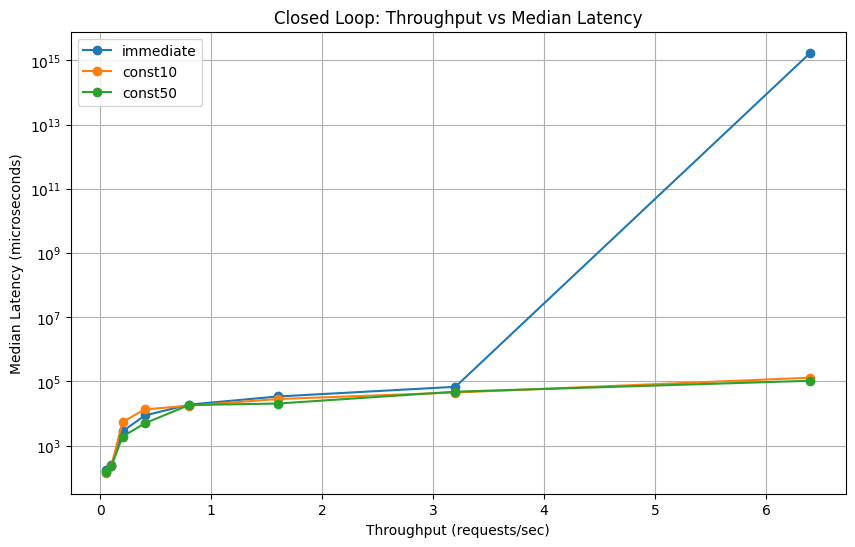

In [9]:
# Load the data
df_path = f"{data_dir}/closed_loop_summary.csv"
df = pd.read_csv(df_path)

# df columns:
# throughput,median_latency,p95_latency,p99_latency,workload,threads
# plot the data for each workload type as separate lines

# plot the throughput-latency graph for all median latencies
# x-axis is the offered load
# y-axis is the latency

plt.figure(figsize=(10, 6))

for workload in df['workload'].unique():
    workload_data = df[df['workload'] == workload]
    plt.plot(workload_data['throughput'], workload_data['median_latency'], 
             marker='o', label=workload)

plt.xlabel('Throughput (requests/sec)')
plt.ylabel('Median Latency (microseconds)')
plt.title('Closed Loop: Throughput vs Median Latency')
plt.legend()
plt.grid(True)
plt.yscale('log')
#plt.xscale('log')
plt.show()


#### Closed Loop P95

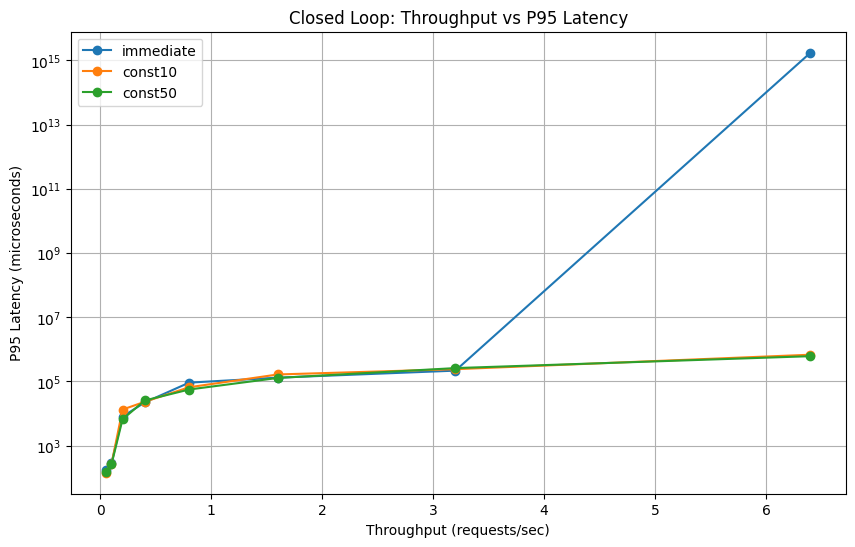

In [11]:
# plot the throughput-latency graph for all p95 latencies
plt.figure(figsize=(10, 6))

for workload in df['workload'].unique():
    workload_data = df[df['workload'] == workload]
    plt.plot(workload_data['throughput'], workload_data['p95_latency'], 
             marker='o', label=workload)

plt.xlabel('Throughput (requests/sec)')
plt.ylabel('P95 Latency (microseconds)')
plt.title('Closed Loop: Throughput vs P95 Latency')
plt.legend()
plt.grid(True)
plt.yscale('log')
#plt.xscale('log')
plt.show()


#### Closed Loop P99

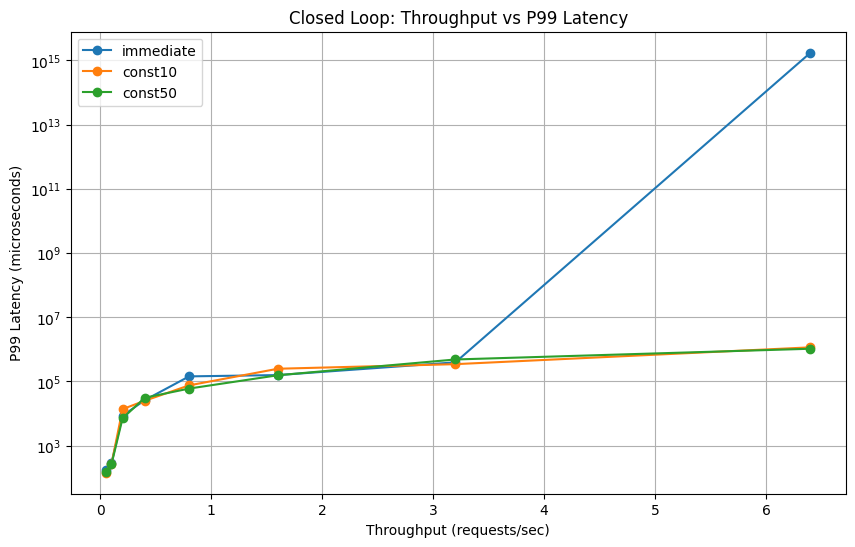

In [12]:
# plot the throughput-latency graph for all p99 latencies
plt.figure(figsize=(10, 6))

for workload in df['workload'].unique():
    workload_data = df[df['workload'] == workload]
    plt.plot(workload_data['throughput'], workload_data['p99_latency'], 
             marker='o', label=workload)

plt.xlabel('Throughput (requests/sec)')
plt.ylabel('P99 Latency (microseconds)')
plt.title('Closed Loop: Throughput vs P99 Latency')
plt.legend()
plt.grid(True)
plt.yscale('log')
#plt.xscale('log')
plt.show()


## Analysis:

Describe the graphs above. Why do they exhibit this pattern?

## Open Loop

### Throughput-Latency Graphs

#### Open Loop Median

#### Open Loop P95

#### Open Loop P99

## Analysis:

Describe the graphs above. Why do they exhibit this pattern?

## Design decisions

List out key design decisions and justify each. Use flamegraphs or perf report from your experiments in the VM